In [1]:
import dill as pickle
import os
from pprint import pprint as pp
import json
import pandas as pd
from pandas.api.types import CategoricalDtype
from copy import deepcopy
from tqdm.notebook import tqdm_notebook as progress_bar
from pathlib import Path
import numpy as np
from datetime import datetime, timedelta

In [10]:
# main_path = Path('../bt_data_runs/archive_df.pkl').resolve()
# main_df = pd.read_pickle(main_path)
new_path = Path('../bt_data_runs/cleaned_archive_df.pkl').resolve()
# updated_df.to_pickle(new_path)
updated_df = pd.read_pickle(new_path)


In [5]:
main_df.tail()

,buy_date,sell_date,buy_price,sale_price,currency_id,run_name,status,sell_price_multiple,buy_volume_multiple,volume_avg_duration,transparent,profit,duration,ROI,monthly_ROI
9157404,2021-10-02,1900-01-01,0.984262,1.004241,ZUSD4,"ZUSD4(90,12,6.0,False)",opened,12,6,90,False,0.019979,64,-98.0,-16.328125
9157405,2021-10-02,1900-01-01,0.984262,1.004241,ZUSD4,"ZUSD4(90,14,6.0,False)",opened,14,6,90,False,0.019979,64,-98.0,-16.328125
9157406,2021-10-02,1900-01-01,0.984262,1.004241,ZUSD4,"ZUSD4(90,16,6.0,False)",opened,16,6,90,False,0.019979,64,-98.0,-16.328125
9157407,2021-10-02,1900-01-01,0.984262,1.004241,ZUSD4,"ZUSD4(90,18,6.0,False)",opened,18,6,90,False,0.019979,64,-98.0,-16.328125
9157408,2021-10-02,1900-01-01,0.984262,1.004241,ZUSD4,"ZUSD4(90,20,6.0,False)",opened,20,6,90,False,0.019979,64,-98.0,-16.328125


In [6]:
main_df.dtypes

buy_date               datetime64[ns]
sell_date              datetime64[ns]
buy_price                     float64
sale_price                    float64
currency_id                    object
run_name                       object
status                       category
sell_price_multiple             int16
buy_volume_multiple             int16
volume_avg_duration             int16
transparent                      bool
profit                        float64
duration                        int16
ROI                           float16
monthly_ROI                   float16
dtype: object

### Functions:
<ol>
<li>A function to update the datatypes of the different columns.-done</li>
<li>A function to calculate profit of the trade for a given row.-done</li>
<li>A function to calculate present price of the currency if the position was not closed.-done</li>
<li>A function to calculate duration of trade in days.-done</li>
<li>A function to calculate ROI.-done</li>
<li>A function to calculate ROI as % for 30 days.-done</li>
<li>A function to return the price of a currency X days after initiating buy. Error handling for not enough data.-done</li>
</ol>

### Aggregate Analysis
<ol>
<li>Total Profit for all trades for a given set of parameters. New df with parameters and profits.</li>
<li>Avg Profit for all trades with a given set of parameters.</li>
<li>Number of trades executed for a given set of parameters.</li>
<li>A template to filter out trades open longer than X days.</li>
</ol>

In [10]:
def apply_functions(raw_df: pd.DataFrame) -> pd.DataFrame:
    df = deepcopy(raw_df)
    # data now pre-typed
    # df = type_raw_dataframe(raw_df)
    df['sale_price']=df.apply(fill_in_open_positions, axis=1)
    df['profit'] = df.apply(calculate_profit, axis=1)
    MaxDate = max_date(df)
    df['duration'] = df.apply(calculate_duration, axis=1, max_date=MaxDate).astype('int16')
    # get rid of 0 priced positions
    df = df[df['buy_price'] > 0]
    df['ROI'] = df.apply(calculate_ROI, axis=1).astype('float16')
    df['monthly_ROI'] = df.apply(calculate_monthly_ROI, axis=1).astype('float16')
    return df

def type_raw_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    cat_status = CategoricalDtype(
        categories=['closed', 'opened'], 
        ordered=True,
        )
    return_df = df.astype(
        {
            'buy_date': 'datetime64',
            'sell_date': 'datetime64',
            'buy_price': 'float64',
            'sale_price': 'float64',
            'currency_id': 'str',
            'run_name': str,
            'status': cat_status,
            'sell_price_multiple': 'int16',
            'buy_volume_multiple': 'int16',
            'volume_avg_duration': 'int16',
            'transparent': bool,

        }, copy=True
    )
    # return_df['buy_date'] = pd.to_datetime(return_df['buy_date'], infer_datetime_format=True)
    # return_df['sell_date'] = pd.to_datetime(return_df['sell_date'], infer_datetime_format=True)
    return return_df

def calculate_profit(row: pd.DataFrame) -> float:
    if row['sale_price'] != -1:
        return row['sale_price'] - row['buy_price']
    else:
        raise ValueError('Sale price not updated, aborting...')

def fill_in_open_positions(row: pd.DataFrame, dated:int=0) -> float:
    if row['sale_price'] > 0:
        return row['sale_price']
    currency = row['currency_id']
    candle_location = Path(f'../downloaded_data/nomics/candles/{currency}.pkl').resolve()
    currency_df = pd.read_pickle(candle_location)
    if dated == 0:
        # return the last candle close price
        return currency_df['close'].iloc[-1]
    else:
        # return the candle close price X days after the buy date
        check_date = pd.to_datetime(row['buy_date'] + pd.Timedelta(days=int(dated)))
        if check_date > currency_df['timestamp'].iloc[-1]:
            raise ValueError(f'{currency} is not available for {check_date}')
        else:
            return currency_df.loc[currency_df['timestamp'] == check_date]['close'].iloc[0]

def max_date(df = pd.DataFrame) -> datetime:
    currency = df['currency_id'].iloc[0]
    candle_location = Path(f'../downloaded_data/nomics/candles/{currency}.pkl').resolve()
    currency_df = pd.read_pickle(candle_location)
    return currency_df['timestamp'].iloc[-1]

def calculate_duration(df: pd.DataFrame, max_date: datetime) -> int:
    if df['status'] == 'opened':
        return (max_date - df['buy_date']).days
    return (df['sell_date'] - df['buy_date']).days

def calculate_ROI(df: pd.DataFrame) -> float:
    net_return = df['profit']-df['buy_price']
    return net_return/df['buy_price']*100

def calculate_monthly_ROI(df: pd.DataFrame) -> float:
    # only run after calculating ROI
    months_held = float(df['duration']/30)
    # catch divide by zero, return absurdly high ROI to filter out later
    if months_held < 0.01:
        return 1000
    monthly_ROI = ((df['ROI']+1) ** (1/months_held) - 1) * 100
    return monthly_ROI



In [11]:
updated_df = apply_functions(main_df)
# 4.5k currencies took 46 minutes to run
# all currencies took 1.5 hours to run

C:\Users\Gamer\AppData\Local\pypoetry\Cache\virtualenvs\crypto-vol-scanner-Rel0uyg_-py3.9\lib\site-packages\pandas\core\dtypes\cast.py:1201: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


In [12]:
updated_df.dtypes

buy_date               datetime64[ns]
sell_date              datetime64[ns]
buy_price                     float64
sale_price                    float64
currency_id                    object
run_name                       object
status                       category
sell_price_multiple             int16
buy_volume_multiple             int16
volume_avg_duration             int16
transparent                      bool
profit                        float64
duration                        int16
ROI                           float16
monthly_ROI                   float16
dtype: object

In [222]:
import sys
print("base size in MB",sys.getsizeof(main_df)/(1024*1024))
print("completed analysis size in MB",sys.getsizeof(updated_df)/(1024*1024))


base size in MB 792.2067975997925
completed analysis size in MB 822.7501363754272


In [65]:
closed_df = updated_df[(updated_df['status']=='closed') & ( updated_df['duration'] <= 5) & (updated_df['currency_id'] == 'DAO1POS')]
# closed_df[['duration','ROI']].describe(datetime_is_numeric=True)
# closed_df.plot(x='duration', y='ROI', c='sell_price_multiple', colormap='viridis', kind='scatter', figsize=(20,10), logx=True, logy=True)
# closed_df.groupby()
closed_df.value_counts(['buy_date'])
# updated_df[updated_df['currency_id']=='PEE']

# TADP           2016
# INNBCBEP20     1980
# DAO1POS        1962
# TASTE          1928
# BNX4           1926

buy_date  
2021-11-30    1962
dtype: int64

##### Further research points
<ul>
<li>break backtrader into smaller parts</li>
<li>Avg Vol at trigger date (to buy)</li>
<li>Correlation of volume to profit. What is meaningful volume?</li>
<li>Consideration for forced exit after X days. Will increase overall ROI? What's the profile of a loser?</li>
<li>Consideration if not in profit after X days, exit.</li>
<li>Come up with simplifying criteria.</li>
    <ul>
    <li>volume must be meaningful to be considered.</li>
    <li>show as different percentiles</li>
    <li>maximum getting out of trade value is target multiple</li>
    </ul>
</ul>

<AxesSubplot:xlabel='buy_date', ylabel='duration'>

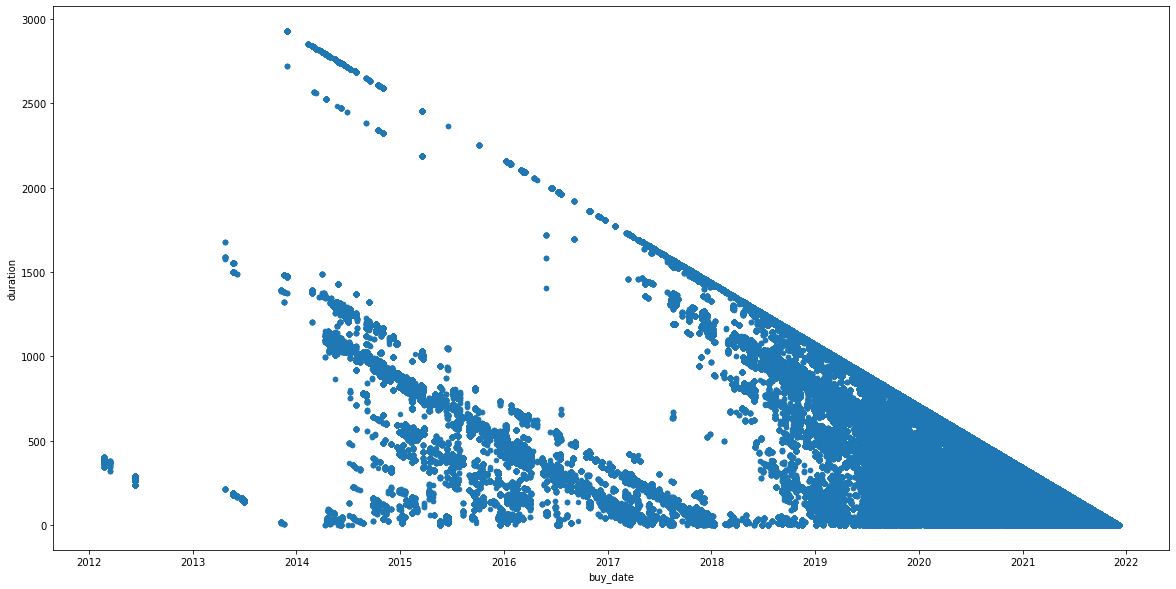

In [74]:
# updated_df[(updated_df['monthly_ROI']==np.Infinity) & (updated_df['duration']<5)].groupby(['duration','buy_volume_multiple'])['monthly_ROI'].count()
filtered_df = updated_df[(updated_df['monthly_ROI']==np.Infinity)] #  & (updated_df['duration']<30)]
# filtered_df['monthly_ROI']=
# updated_df.plot(x='buy_price', y='sale_price', c='sell_price_multiple', colormap='viridis', kind='scatter', figsize=(20,10), logx=True, logy=True)
updated_df.plot(x='buy_date', y='duration', kind='scatter', figsize=(20,10))

In [157]:
buy_prices = main_df[main_df['buy_price'] > 0]

In [205]:
df['buy_date'].describe(datetime_is_numeric=True)

count                      9
mean     2021-11-01 00:00:00
min      2021-11-01 00:00:00
25%      2021-11-01 00:00:00
50%      2021-11-01 00:00:00
75%      2021-11-01 00:00:00
max      2021-11-01 00:00:00
Name: buy_date, dtype: object

In [45]:
updated_df.shape

(8457696, 15)

<AxesSubplot:xlabel='timestamp'>

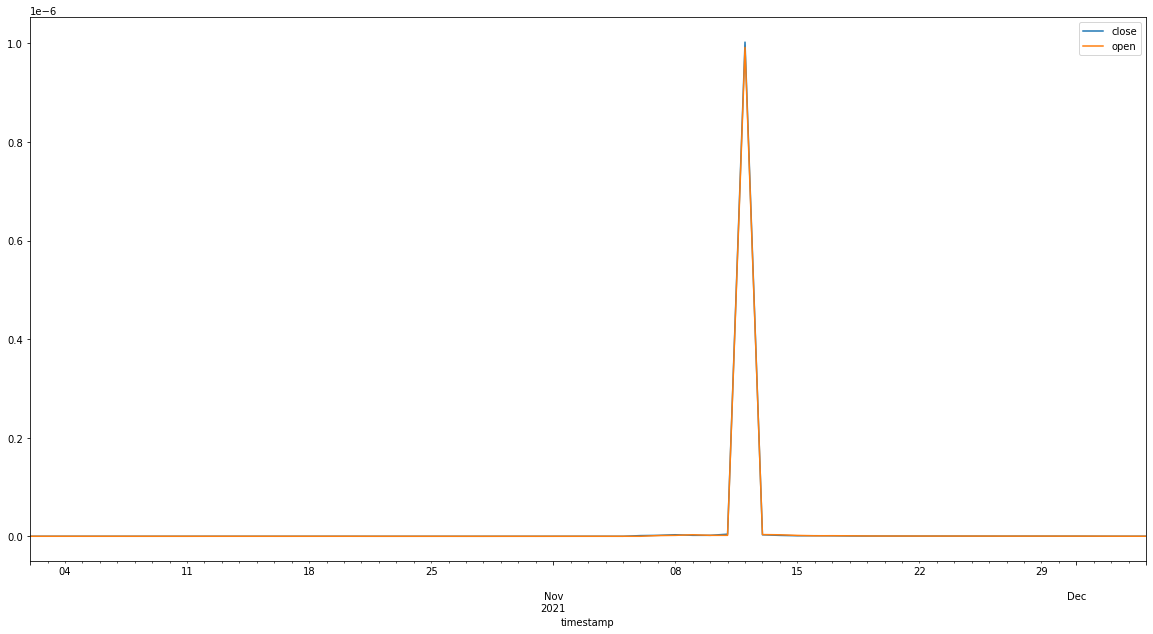

In [73]:
tadp = pd.read_pickle(Path(f'../downloaded_data/nomics/candles/TADP.pkl').resolve())
tadp = tadp.loc[tadp['timestamp'] > '2021-10-01']
tadp.plot(x='timestamp', y=['close', 'open'], kind='line', figsize=(20,10), subplots=False)

In [75]:
os.cpu_count()

28

In [1]:
import multiprocessing
multiprocessing.cpu_count() * 6 // 7

24

In [3]:
bob = ({
"currency": 'USD',
"VolAvgParam": 12,
"TriggerVolParam": 4,
"transparent": True,
})
print(**bob)

currency VolAvgParam TriggerVolParam transparent


In [21]:
import pandas as pd
from pathlib import Path

df = pd.read_pickle(Path(f'../bt_data_runs/aggregated_archive_df.pkl').resolve())

<AxesSubplot:xlabel='buy_date', ylabel='buy_avg_volume'>

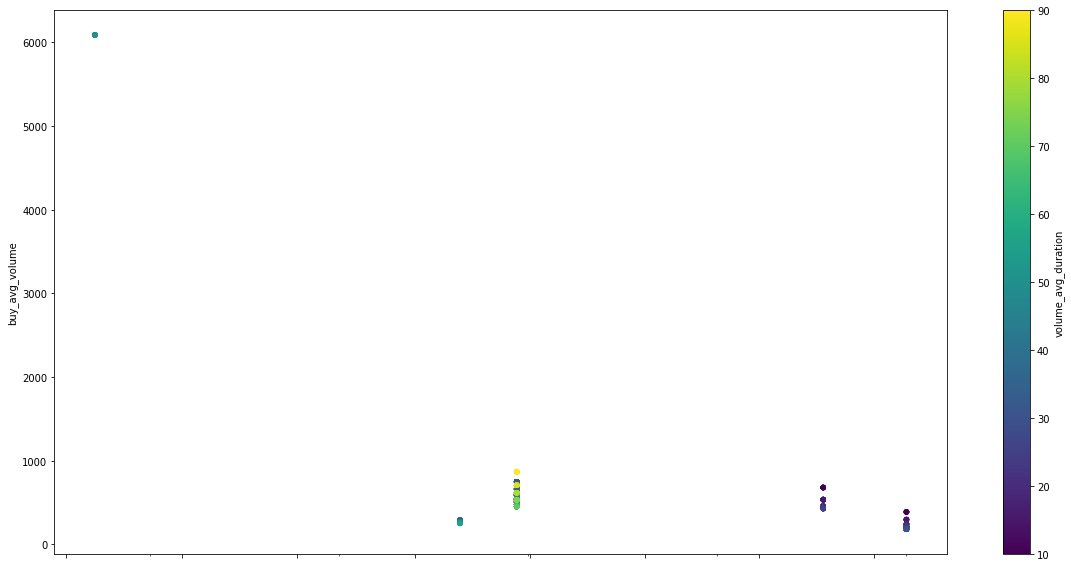

In [22]:

df.plot(x='buy_date', y='buy_avg_volume', c='volume_avg_duration', cmap='viridis', kind='scatter', figsize=(20,10), subplots=False, logy=False)

In [16]:
filtered_df = df[(df['buy_date']==pd.to_datetime('2017-3-17'))]
filtered_df['currency_id'].value_counts()

ETH    225
Name: currency_id, dtype: int64

In [24]:
df.shape

(1629, 12)

In [27]:
from alive_progress import alive_bar
import time

with alive_bar(10, theme='smooth') as bar:
    for i in range(10):
        time.sleep(0.25)
        bar()

|████████████████████████████████████████| 10/10 [100%] in 2.6s (3.89/s)
